In [3]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
# reference https://github.com/rlabbe/filterpy

# visualiation
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import datetime


In [39]:
# read CSV file
traj_lens = np.loadtxt('./Trajectory/data0503/traj_lens.csv')
print(f"number of trajectories = {len(traj_lens)}")

traj_start = np.zeros((len(traj_lens)+1,1), dtype=int)
# traj_end = np.zeros((len(traj_lens),1))
idx = 1
for length in traj_lens[:]:
    traj_start[idx] = traj_start[idx - 1] + length
    # traj_end[idx-1] = traj_start[idx] - 1
    idx = idx + 1

# traj_end[-1] = traj_lens[-1] + traj_end[-2] - 1

original_position_list = np.loadtxt('./Trajectory/data0503/original_position_list.csv')
position_noise_01 = np.loadtxt('./Trajectory/data0503/position_noise_0.1.csv')
position_noise_1 = np.loadtxt('./Trajectory/data0503/position_noise_1.csv')
position_noise_2 = np.loadtxt('./Trajectory/data0503/position_noise_2.csv')
position_noise_5 = np.loadtxt('./Trajectory/data0503/position_noise_5.csv')

position_no_outlier = np.loadtxt('./Trajectory/data/outlier_0.01-c/ori_position.csv')
position_outlier_001 = np.loadtxt('./Trajectory/data/outlier_0.01-c/with_outlier_position.csv')

outlier_indices = np.loadtxt('./Trajectory/data/outlier_0.01-c/outlier_indices.csv', delimiter=' ')
outlier_indices = outlier_indices.astype(int)


number of trajectories = 100


In [42]:


def plot_trajectory(x, title, outliers=[]):
    x = np.array(x)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)
    plt.title(title)
    xline = x[:,0]
    yline = x[:,1]
    zline = x[:,2]
    ax.plot3D(xline, yline, zline, 'green')
    for o in outliers:
        if o != 0 and o != len(x) - 1:
            xline = x[o-1:o+1, 0]
            yline = x[o-1:o+1, 1]
            zline = x[o-1:o+1, 2]
            ax.plot3D(xline, yline, zline, 'red')

def plot_compare(x1, x2, title, label1, label2):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    plt.title(title)
    ax.set_xlim3d(0,100)
    ax.set_ylim3d(0,100)
    ax.set_zlim3d(0,100)

    xline = x1[:,0]
    yline = x1[:,1]
    zline = x1[:,2]
    ax.plot3D(xline, yline, zline, 'red')

    xline = x2[:,0]
    yline = x2[:,1]
    zline = x2[:,2]
    ax.plot3D(xline, yline, zline, 'blue')

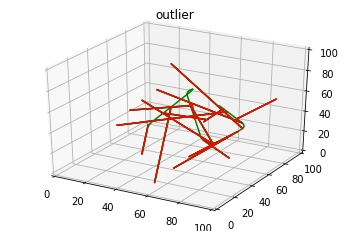

In [43]:
##### Define Data being used


# traject_select = 10
# original = original_position_list[traj_start[traject_select][0]: traj_start[traject_select+1][0]][:]
# noisy = position_noise_5[traj_start[traject_select][0]: traj_start[traject_select+1][0]][:]
# outlier = position_outlier_001[traj_start[traject_select][0]: traj_start[traject_select+10][0]][:]

original = position_no_outlier[:2000]
outlier = position_outlier_001[:2000]
plot_trajectory(outlier, "outlier",outlier_indices)

## Kalman Filter Method

In [45]:

def initialise_filter(filter):

    dt = 0.01 # constant sampling time



    # transition matrix
    filter.F = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]]
    )

    # measurement matrix
    filter.H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0]]
    )

    ## tunable parameters

    # covariance matrix
    filter.P *= 1000 


    # measurement noise
    filter.R = np.diag([0.5, 0.5, 0.5])

    # process noise
    filter.Q = np.diag([1e-3,1e-3,1e-3, 1e-2, 1e-2, 1e-2]) #Q_discrete_white_noise(3, dt, .1)



### Filtering Outlier

In [46]:
filter = KalmanFilter(dim_x=6, dim_z=3) # internal state has x,y,z,vx,vy,vz

initialise_filter(filter)

# feeding data to kalman filter

# initialise the state
initial_guess = np.concatenate([outlier[0],np.array([0,0,0])])
filter.x = initial_guess

np.set_printoptions(precision=2);

# prediction
filtered = np.zeros((outlier.shape[0],6))
filtered[0] = initial_guess # no filter available yet
for i in range(outlier.shape[0]):

    if i == 0:
        # print(f"{outlier[i]} and {filter.x}")
        continue

    filter.predict()
    error = outlier[i] - filter.x[0:3]
    filter.update(outlier[i])

    filtered[i] = filter.x

mean Euclidean distance error = 0.6706913877433708


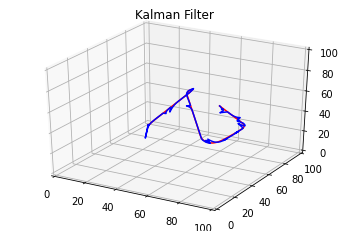

In [48]:
def meanEuclideanDistanceError(pred, real):
    error = 0
    big_error_count = 0
    for i in range(len(pred)):        
        point = pred[i]    
        de =    ((real[i][0] - point[0]) ** 2 + (real[i][1] - point[1]) ** 2 + (real[i][2] - point[2]) ** 2) ** 0.5
        error += de
        if de > 1:
            big_error_count = big_error_count +1
    # print (f"{error} {big_error_count}")
    return error/len(real)

meane = meanEuclideanDistanceError(filtered, original)
print(f"mean Euclidean distance error = {meane}")


plot_compare(original, filtered[:,0:3],"Kalman Filter","original","filtered")

## Non-Linear Least Squre Approach

In [49]:
import scipy.optimize as optimisation
import copy
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
# https://python4mpia.github.io/fitting_data/least-squares-fitting.html

def residual(estimated, alpha, data):


    # smoothness constraint by minimising pairwise distance
    estimated = np.reshape(estimated,(-1,3))

    smoothness_loss = -np.diff(estimated, axis=0) # latter subtracted by the former
    smoothness_loss = np.append(smoothness_loss,[[0,0,0]], axis=0)


    data_loss = estimated - data
    
    resid = (smoothness_loss + alpha * data_loss).flatten()

    return resid
    

In [9]:
x0 = copy.deepcopy(outlier).flatten()
# print(x0)
alpha = 0.05

print(f"data points number = {outlier.shape[0]}")


a = datetime.datetime.now()
res_1 = optimisation.least_squares(residual, x0, args=(alpha, outlier), verbose=2, ftol=1e-2)
b = datetime.datetime.now()
print(b-a)


data points number = 2000
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4527e+04                                    1.80e+02    
       1              2         8.6909e-12      5.45e+04       2.43e+02       2.60e-06    
       2              3         4.5568e-26      8.69e-12       1.25e-05       2.77e-14    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 5.4527e+04, final cost 4.5568e-26, first-order optimality 2.77e-14.
0:05:33.053827


mean Euclidean distance error = 2.1148283759058626


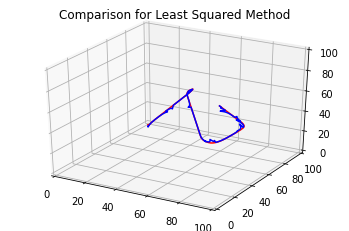

In [52]:
lqx = np.reshape(res_1.x, [-1,3])


def meanEuclideanDistanceError(pred, real):
    error = 0
    big_error_count = 0
    for i in range(len(pred)):        
        point = pred[i]    
        de =    ((real[i][0] - point[0]) ** 2 + (real[i][1] - point[1]) ** 2 + (real[i][2] - point[2]) ** 2) ** 0.5
        error += de
        if de > 1:
            big_error_count = big_error_count +1
    # print (f"{error} {big_error_count}")
    return error/len(real)


meane = meanEuclideanDistanceError(lqx, original)
print(f"mean Euclidean distance error = {meane}")

plot_compare(original, lqx,"Comparison for Least Squared Method","original","leastsq")
# plot_trajectory(noisy,"outliers", outlier_indices)